In [39]:
import tensorflow as tf
boston_housing = tf.keras.datasets.boston_housing

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path="boston_housing.npz", test_split=0.2, seed=113
)

In [40]:
print(f'Zbiór uczący: {x_train.shape}, zbiór walidacyjny: {x_test.shape}')
x_train[1]

Zbiór uczący: (404, 13), zbiór walidacyjny: (102, 13)


array([2.1770e-02, 8.2500e+01, 2.0300e+00, 0.0000e+00, 4.1500e-01,
       7.6100e+00, 1.5700e+01, 6.2700e+00, 2.0000e+00, 3.4800e+02,
       1.4700e+01, 3.9538e+02, 3.1100e+00])

In [41]:
#Przeprowadziłam normalizację funkcji/cech. 
#Normalizacja cech polega na odjęciu średniej cechy od każdej cechy
#i podzieleniu każdego wyniku przez odchylenie standardowe.  
import numpy as np

train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train = (x_train - train_mean) / train_std
print(f'Zbiór uczący: {x_train.shape}, zbiór walidacyjny: {x_test.shape}')
x_train[1]

Zbiór uczący: (404, 13), zbiór walidacyjny: (102, 13)


array([-0.40342651,  2.99178419, -1.33391162, -0.25683275, -1.21518188,
        1.89434613, -1.91036058,  1.24758524, -0.85646254, -0.34843254,
       -1.71818909,  0.43190599, -1.32920239])

In [61]:
from tensorflow.keras.models import Sequential 
from keras import layers
from tensorflow import keras

def build_model():
  model = keras.Sequential()
  model.add(layers.Dense(20, activation='relu', input_shape=(x_train.shape[1],)))
  #model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))

  model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse'])
  return model

In [62]:
import pandas as pd #for visualization

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(x_test, y_test,
                    epochs=1000,
                    verbose=0,
                    validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# sprawdzam RMSE miara, aby porównać się z najlepszymi osiągami: https://www.kaggle.com/c/boston-housing/leaderboard
rmse_final = np.sqrt(float(hist['val_mae'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

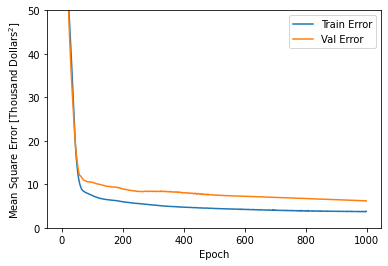

In [63]:
#Jak przebiegał proces uczenia się - funkcja straty dla zbioru treningowego i validacyjnego
import matplotlib.pyplot as plt

def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

plot_history()

In [84]:
x_test_norm = (x_test - train_mean) / train_std
mse, score, _ = model.evaluate(x_test_norm, y_test)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))
print(score)

4/4 [==============================] - 0s 2ms/step - loss: 31.8926 - mae: 4.3649 - mse: 31.8926
Root Mean Square Error on test set: 5.647
4.364914894104004


In [80]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print(f'Processing fold # {i}')
    val_data = x_train[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
                            [x_train[:i * num_val_samples],
                            x_train[(i+1) * num_val_samples:]],
                            axis=0)
    partial_train_targets = np.concatenate(
                            [y_train[:i * num_val_samples],
                            y_train[(i+1)*num_val_samples:]],
                            axis=0)
    model = build_model()
    model.fit(partial_train_data,
              partial_train_targets,
              epochs=num_epochs,
              verbose=0)
    val_mse, _, _ = model.evaluate(val_data, val_targets)
    all_scores.append(hist['val_mae'])

Processing fold # 0
4/4 [==============================] - 0s 3ms/step - loss: 26.9341 - mae: 3.5551 - mse: 26.9341
Processing fold # 1
4/4 [==============================] - 0s 3ms/step - loss: 24.4590 - mae: 3.7403 - mse: 24.4590
Processing fold # 2
4/4 [==============================] - 0s 3ms/step - loss: 30.3019 - mae: 3.9647 - mse: 30.3019
Processing fold # 3
4/4 [==============================] - 0s 3ms/step - loss: 39.1068 - mae: 4.4166 - mse: 39.1068


In [81]:
print(f'all_scores : {all_scores}')
print(f'mean all scores : {np.mean(all_scores)}')

all_scores : [0      170.202805
1      161.523010
2      152.969376
3      144.664398
4      136.591400
          ...    
995      6.215484
996      6.206177
997      6.200435
998      6.179013
999      6.192567
Name: val_mae, Length: 1000, dtype: float64, 0      170.202805
1      161.523010
2      152.969376
3      144.664398
4      136.591400
          ...    
995      6.215484
996      6.206177
997      6.200435
998      6.179013
999      6.192567
Name: val_mae, Length: 1000, dtype: float64, 0      170.202805
1      161.523010
2      152.969376
3      144.664398
4      136.591400
          ...    
995      6.215484
996      6.206177
997      6.200435
998      6.179013
999      6.192567
Name: val_mae, Length: 1000, dtype: float64, 0      170.202805
1      161.523010
2      152.969376
3      144.664398
4      136.591400
          ...    
995      6.215484
996      6.206177
997      6.200435
998      6.179013
999      6.192567
Name: val_mae, Length: 1000, dtype: float64]
mean all score